In [99]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import BaseCrossValidator
import matplotlib.pyplot as plt
import random
import optuna


In [100]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [101]:
nasa_df = pd.read_csv('../Datasets/nasa_Interp_flat.csv')
nasa_df.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,q_interp_0,q_interp_1,q_interp_2,q_interp_3,q_interp_4,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,B0052,2.0,0,0.860659,0.430330,0.863618,0.863618,0.863618,0.863618,0.858994,...,9.127700,9.127700,9.127700,9.127700,9.127700,9.127700,9.127700,9.127700,9.127700,9.127700
1,B0052,2.0,4,1.418310,0.709155,1.420885,1.420885,1.404464,1.365268,1.326072,...,5.604885,5.604885,5.604885,5.604885,5.604885,5.604885,5.604885,5.604885,5.604885,5.604885
2,B0052,2.0,6,1.370712,0.685356,1.373463,1.373463,1.373463,1.361429,1.336960,...,5.598362,5.598362,5.598362,5.598362,5.598362,5.598362,5.598362,5.598362,5.598362,5.598362
3,B0052,2.0,8,1.351565,0.675782,1.354291,1.354291,1.354291,1.354291,1.354291,...,4.992694,4.992694,4.992694,4.992694,4.992694,4.992694,4.992694,4.992694,4.992694,4.992694
4,B0050,2.0,0,0.863145,0.431572,0.946663,0.946663,0.946663,0.888116,0.812101,...,9.269791,9.269791,9.269791,9.269791,9.269791,9.269791,9.269791,9.269791,9.269791,9.269791


In [102]:
oxford_df = pd.read_csv('../Datasets/oxford_Interp_flat.csv')
oxford_df.head()

,cell_id,cycle_index,capacity,soh,voltage_raw,charge_raw,temperature_raw,time_raw,q_interp_0,q_interp_1,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,Cell1,0,0.739111,0.998799,"[4.1912351, 4.1757555, 4.1743121, 4.1726279, 4...","[-0.0, 0.0001948313260934485, 0.00039978834191...","[40.026463, 40.051395, 39.988987, 39.976521, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.720836,0.720900,...,39.970291,39.967860,39.965425,39.962987,39.960546,39.958101,39.955654,39.953203,39.950750,39.948294
1,Cell1,100,0.730193,0.986747,"[4.1926785, 4.1765175, 4.1749935, 4.1737504, 4...","[-0.0, 0.00019481252778942048, 0.0003997496296...","[39.964054, 39.8517, 39.876675, 39.914112, 39....","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.718104,0.718055,...,39.868830,39.868614,39.868491,39.868465,39.868536,39.868707,39.868979,39.869354,39.869834,39.870422
2,Cell1,200,0.725747,0.980739,"[4.1929593, 4.1769986, 4.1752744, 4.1739912, 4...","[-0.0, 0.00019479553618175448, 0.0003997179553...","[39.914112, 39.901646, 39.876675, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",0.716575,0.716481,...,39.842586,39.839024,39.835395,39.831697,39.827929,39.824091,39.820181,39.816198,39.812141,39.808010
3,Cell1,300,0.722843,0.976815,"[4.192502, 4.1766214, 4.1748571, 4.1732931, 4....","[-0.0, 0.000194722652140273, 0.000399565470333...","[39.926579, 39.876675, 39.976521, 39.901646, 3...","[0.0, 1.0000046342611313, 1.9999992102384567, ...",0.715259,0.715138,...,39.846698,39.843177,39.839596,39.835955,39.832253,39.828488,39.824659,39.820767,39.816809,39.812785
4,Cell1,400,0.718367,0.970766,"[4.1927824, 4.1767821, 4.1753383, 4.1738949, 4...","[-0.0, 0.00019478713911181032, 0.0003996975935...","[39.876675, 39.926579, 39.926579, 39.864166, 3...","[0.0, 0.9999945759773254, 1.9999992102384567, ...",0.713821,0.713647,...,39.870769,39.869795,39.868855,39.867950,39.867079,39.866243,39.865444,39.864681,39.863955,39.863266


In [103]:
isu_df = pd.read_csv('../Datasets/isu_Interp_flat.csv')
isu_df.rename(columns={'rpt_index': 'cycle_index'}, inplace=True)
isu_df.head()

,cell_id,cycle_index,capacity,soh,q_interp_0,q_interp_1,q_interp_2,q_interp_3,q_interp_4,q_interp_5,...,e_interp_990,e_interp_991,e_interp_992,e_interp_993,e_interp_994,e_interp_995,e_interp_996,e_interp_997,e_interp_998,e_interp_999
0,G1C1,0,0.280457,1.121826,0.280745,0.280712,0.280681,0.280649,0.280618,0.280587,...,0.001518,0.001288,0.001067,0.000856,0.000655,0.000464,0.000282,0.000111,-0.000050,-0.000201
1,G1C1,1,0.279856,1.119422,0.279864,0.279845,0.279826,0.279808,0.279789,0.279771,...,0.001168,0.000777,0.000388,0.000003,-0.000380,-0.000759,-0.001136,-0.001510,-0.001881,-0.002250
2,G1C1,2,0.278479,1.113917,0.278299,0.278290,0.278280,0.278270,0.278260,0.278250,...,0.001739,0.001386,0.001040,0.000701,0.000368,0.000042,-0.000277,-0.000589,-0.000895,-0.001195
3,G1C1,3,0.277190,1.108761,0.276854,0.276852,0.276850,0.276848,0.276845,0.276842,...,0.002239,0.001939,0.001650,0.001372,0.001105,0.000848,0.000603,0.000368,0.000145,-0.000067
4,G1C1,4,0.276860,1.107439,0.276685,0.276676,0.276666,0.276657,0.276647,0.276637,...,0.001882,0.001513,0.001151,0.000797,0.000451,0.000113,-0.000218,-0.000541,-0.000857,-0.001165


In [104]:
common_cols = [col for col in nasa_df.columns if col in oxford_df.columns and col in isu_df.columns]
common_cols = list(common_cols)

for i in range(0, len(common_cols), 10):
    print(', '.join(common_cols[i:i+10]))


cell_id, cycle_index, capacity, soh, q_interp_0, q_interp_1, q_interp_2, q_interp_3, q_interp_4, q_interp_5
q_interp_6, q_interp_7, q_interp_8, q_interp_9, q_interp_10, q_interp_11, q_interp_12, q_interp_13, q_interp_14, q_interp_15
q_interp_16, q_interp_17, q_interp_18, q_interp_19, q_interp_20, q_interp_21, q_interp_22, q_interp_23, q_interp_24, q_interp_25
q_interp_26, q_interp_27, q_interp_28, q_interp_29, q_interp_30, q_interp_31, q_interp_32, q_interp_33, q_interp_34, q_interp_35
q_interp_36, q_interp_37, q_interp_38, q_interp_39, q_interp_40, q_interp_41, q_interp_42, q_interp_43, q_interp_44, q_interp_45
q_interp_46, q_interp_47, q_interp_48, q_interp_49, q_interp_50, q_interp_51, q_interp_52, q_interp_53, q_interp_54, q_interp_55
q_interp_56, q_interp_57, q_interp_58, q_interp_59, q_interp_60, q_interp_61, q_interp_62, q_interp_63, q_interp_64, q_interp_65
q_interp_66, q_interp_67, q_interp_68, q_interp_69, q_interp_70, q_interp_71, q_interp_72, q_interp_73, q_interp_74, q_int

In [105]:
def merge_battery_datasets(datasets: dict):
    """
    Merge battery datasets with a 'source' column indicating origin.

    Args:
        datasets (dict): Dictionary of DataFrames with keys as source names.
                         Example: {'nasa': nasa_df, 'oxford': oxford_df}

    Returns:
        pd.DataFrame: Merged DataFrame with 'source' column
    """
    dfs = []
    for name, df in datasets.items():
        df_copy = df.copy()
        df_copy['source'] = name
        dfs.append(df_copy)

    return pd.concat(dfs, ignore_index=True)


In [106]:
df_merged = merge_battery_datasets({
    'nasa': nasa_df,
    'oxford': oxford_df,
    'isu': isu_df
})


In [107]:
missing = df_merged.isnull().sum()
missing = missing[missing > 0]
print(missing)


rated_capacity    5974
t_interp_0        5455
t_interp_1        5455
t_interp_2        5455
t_interp_3        5455
                  ... 
e_interp_995      3398
e_interp_996      3398
e_interp_997      3398
e_interp_998      3398
e_interp_999      3398
Length: 2005, dtype: int64


In [108]:
# ============================
# Sequence Builder
# ============================
def build_lstm_sequences(df, feature_cols, target_col='capacity'):
    X_seq, y_seq = {}, {}
    for cell_id in df['cell_id'].unique():
        df_cell = df[df['cell_id'] == cell_id].sort_values('cycle_index')
        X_seq[cell_id] = df_cell[feature_cols].values.astype(np.float32)
        y_seq[cell_id] = df_cell[target_col].values.astype(np.float32)
    return X_seq, y_seq


In [109]:
# ============================
# Dataset for LSTM
# ============================
class BatterySeqDataset(Dataset):
    def __init__(self, X_seq_dict, y_seq_dict):
        self.X = list(X_seq_dict.values())
        self.y = list(y_seq_dict.values())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate_fn(batch):
    x_seqs, y_seqs = zip(*batch)

    x_padded = pad_sequence(x_seqs, batch_first=True)  
    y_padded = pad_sequence(y_seqs, batch_first=True) 
    
    return x_padded, y_padded


In [111]:
# ============================
# LSTM Model
# ============================
class BatteryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=1, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])  # Predict last timestep

In [112]:
# ============================
# Cross Validator
# ============================
class BatteryWiseSplit(BaseCrossValidator):
    def __init__(self, n_splits=5, random_state=None, column_group='source'):
        self.n_splits = n_splits
        self.random_state = random_state
        self.column_group = column_group

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        df = X.copy()
        if 'cell_id' not in df.columns or self.column_group not in df.columns:
            raise ValueError("DataFrame must contain 'cell_id' and column group.")

        rng = np.random.RandomState(self.random_state)
        unique_batteries = df[["cell_id", self.column_group]].drop_duplicates()
        batteries_by_source = unique_batteries.groupby(self.column_group)["cell_id"].apply(list)
        folds = [[] for _ in range(self.n_splits)]

        for source, battery_list in batteries_by_source.items():
            rng.shuffle(battery_list)
            for i, cell_id in enumerate(battery_list):
                folds[i % self.n_splits].append(cell_id)

        for i in range(self.n_splits):
            val_batteries = set(folds[i])
            train_batteries = set(unique_batteries["cell_id"]) - val_batteries
            train_idx = df[df["cell_id"].isin(train_batteries)].index.values
            val_idx = df[df["cell_id"].isin(val_batteries)].index.values
            yield train_idx, val_idx


In [113]:
# # ============================
# # Trainer Class
# # ============================
# class BatteryTrainer:
#     def __init__(self, df, target_cols, max_q=100, max_i=100, normalize=True, verbose=True, batch_size = 1):
#         self.df = df.copy()
#         self.target_cols = target_cols
#         self.verbose = verbose
#         self.batch_size = batch_size

#         # Infer 'source' from 'cell_id' prefix
#         if 'source' not in self.df.columns:
#             self.df['source'] = self.df['cell_id'].apply(self._infer_source)

#         if normalize:
#             self.df = self.normalize_per_source(self.df)

#         q_cols = [c for c in df.columns if c.startswith('q_interp_')][:max_q]
#         i_cols = [c for c in df.columns if c.startswith('i_interp_')][:max_i]
#         self.feature_cols = q_cols + i_cols + ['cycle_index']

#         self._prepare_data()

#     def _infer_source(self, cell_id):
#         if str(cell_id).startswith('B'):
#             return 'nasa'
#         elif str(cell_id).startswith('Cell'):
#             return 'oxford'
#         elif str(cell_id).startswith('G'):
#             return 'isu'
#         else:
#             return 'unknown'

#     def normalize_per_source(self, df, exclude_cols=['capacity', 'soh']):
#         numeric_cols = df.select_dtypes(include='number').columns.tolist()
#         columns_base = [col for col in numeric_cols if col not in exclude_cols]

#         normalized_data = []

#         for src in df['source'].unique():
#             sub_df = df[df['source'] == src].copy()

#             # Filter columns per-group based on <50% NaN
#             columns_to_normalize = [col for col in columns_base if sub_df[col].isna().mean() < 0.5]

#             if sub_df[columns_to_normalize].dropna().shape[0] == 0:
#                 print(f" Skipping source={src} — all NaNs in features")
#                 continue

#             for col in columns_to_normalize:
#                 sub_df[col] = sub_df[col].fillna(sub_df[col].mean())

#             try:
#                 scaler = StandardScaler()
#                 sub_df[columns_to_normalize] = scaler.fit_transform(sub_df[columns_to_normalize])
#                 normalized_data.append(sub_df)
#                 if self.verbose:
#                     print(f" Normalized source={src} with {len(columns_to_normalize)} features")
#             except Exception as e:
#                 print(f" Skipping source={src} due to error: {e}")

#         if not normalized_data:
#             raise ValueError("No valid groups found during normalization. Check for missing data or too many NaNs.")

#         return pd.concat(normalized_data, ignore_index=True)
    
#     def _prepare_data(self):
#         splitter = BatteryWiseSplit(n_splits=5, random_state=42, column_group='source')
#         self.df = self.df.reset_index(drop=True)
#         train_idx, test_idx = next(splitter.split(self.df))

#         self.train_idx = train_idx
#         self.test_idx = test_idx

#         train_df = self.df.iloc[train_idx].copy()
#         test_df = self.df.iloc[test_idx].copy()

#         self.scaler = StandardScaler()
#         self.scaler.fit(train_df[self.feature_cols])
#         train_df[self.feature_cols] = self.scaler.transform(train_df[self.feature_cols])
#         test_df[self.feature_cols] = self.scaler.transform(test_df[self.feature_cols])


#         X_train_seq, y_train_seq = build_lstm_sequences(train_df, self.feature_cols, self.target_cols[0])
#         X_test_seq, y_test_seq = build_lstm_sequences(test_df, self.feature_cols, self.target_cols[0])

#         self.train_loader = DataLoader(
#             BatterySeqDataset(X_train_seq, y_train_seq),
#             batch_size=self.batch_size,
#             shuffle=True,
#             collate_fn=pad_collate_fn  # ✅ padding enabled
#         )

#         self.val_loader = DataLoader(
#             BatterySeqDataset(X_test_seq, y_test_seq),
#             batch_size=self.batch_size,
#             collate_fn=pad_collate_fn  # ✅ padding enabled
#         )


#     def train(self, epochs=20, lr=1e-3):
#         self.model = BatteryLSTM(input_dim=len(self.feature_cols), output_dim=1)
#         optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
#         criterion = nn.MSELoss()

#         self.train_mse, self.val_mse = [], []
#         self.train_mae, self.val_mae = [], []
#         self.train_r2, self.val_r2 = [], []

#         for epoch in range(epochs):
#             self.model.train()
#             preds, targets = [], []
#             for xb, yb in self.train_loader:
#                 pred = self.model(xb).squeeze(-1)
#                 loss = criterion(pred, yb[:, -1])
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 preds.append(pred.detach().numpy())
#                 targets.append(yb[:, -1].numpy())

#             preds = np.concatenate(preds)
#             targets = np.concatenate(targets)
#             self.train_mse.append(mean_squared_error(targets, preds))
#             self.train_mae.append(mean_absolute_error(targets, preds))
#             self.train_r2.append(r2_score(targets, preds))

#             self.model.eval()
#             val_preds, val_targets = [], []
#             with torch.no_grad():
#                 for xb, yb in self.val_loader:
#                     pred = self.model(xb).squeeze(-1)
#                     val_preds.append(pred.numpy())
#                     val_targets.append(yb[:, -1].numpy())
#             val_preds = np.concatenate(val_preds)
#             val_targets = np.concatenate(val_targets)
#             self.val_mse.append(mean_squared_error(val_targets, val_preds))
#             self.val_mae.append(mean_absolute_error(val_targets, val_preds))
#             self.val_r2.append(r2_score(val_targets, val_preds))

#             print(f"Epoch {epoch+1}: Train MSE={self.train_mse[-1]:.4f}, Val MSE={self.val_mse[-1]:.4f}")

#     def plot_metrics(self):
#         epochs = range(1, len(self.train_mse) + 1)

#         plt.figure()
#         plt.plot(epochs, self.train_mse, label="Train MSE")
#         plt.plot(epochs, self.val_mse, label="Val MSE")
#         plt.title("MSE vs Epoch")
#         plt.xlabel("Epoch")
#         plt.ylabel("MSE")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#         plt.figure()
#         plt.plot(epochs, self.train_mae, label="Train MAE")
#         plt.plot(epochs, self.val_mae, label="Val MAE")
#         plt.title("MAE vs Epoch")
#         plt.xlabel("Epoch")
#         plt.ylabel("MAE")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#         plt.figure()
#         plt.plot(epochs, self.train_r2, label="Train R²")
#         plt.plot(epochs, self.val_r2, label="Val R²")
#         plt.title("R² vs Epoch")
#         plt.xlabel("Epoch")
#         plt.ylabel("R²")
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#     def plot_split_distribution(self):
#         import numpy as np
#         df_train = self.df.iloc[self.train_idx]
#         df_test = self.df.iloc[self.test_idx]

#         train_counts = df_train['cell_id'].value_counts().sort_index()
#         test_counts = df_test['cell_id'].value_counts().sort_index()
#         all_cell_ids = sorted(set(self.df['cell_id']))
#         train_vals = [train_counts.get(cid, 0) for cid in all_cell_ids]
#         test_vals = [test_counts.get(cid, 0) for cid in all_cell_ids]

#         y = np.arange(len(all_cell_ids))
#         height = 0.4

#         plt.figure(figsize=(10, max(6, len(all_cell_ids) * 0.2)))
#         plt.barh(y, train_vals, height=height, label='Train', alpha=0.7)
#         plt.barh(y + height, test_vals, height=height, label='Test', alpha=0.7)
#         plt.yticks(y + height / 2, all_cell_ids, fontsize=6)
#         plt.ylabel('Battery ID')
#         plt.xlabel('Cycle Count')
#         plt.title('Train/Test Split by Battery ID')
#         plt.legend()
#         plt.grid(True, axis='x', linestyle='--', alpha=0.5)
#         plt.tight_layout()
#         plt.show()

In [114]:
# ============================
# Trainer Class
# ============================
class BatteryTrainer:
    def __init__(self, df, target_cols, max_q=100, max_i=100, normalize=True, verbose=True, batch_size=1):
        self.df = df.copy()
        self.target_cols = target_cols
        self.verbose = verbose
        self.batch_size = batch_size

        # Infer 'source' from 'cell_id' prefix
        if 'source' not in self.df.columns:
            self.df['source'] = self.df['cell_id'].apply(self._infer_source)

        self._prepare_data()

    def _infer_source(self, cell_id):
        if str(cell_id).startswith('B'):
            return 'nasa'
        elif str(cell_id).startswith('Cell'):
            return 'oxford'
        elif str(cell_id).startswith('G'):
            return 'isu'
        else:
            return 'unknown'

    def _prepare_data(self):
        splitter = BatteryWiseSplit(n_splits=5, random_state=42, column_group='source')
        self.df = self.df.reset_index(drop=True)
        train_idx, test_idx = next(splitter.split(self.df))

        self.train_idx = train_idx
        self.test_idx = test_idx

        train_df = self.df.iloc[train_idx].copy()
        test_df = self.df.iloc[test_idx].copy()

        train_df, test_df = self.normalize_per_source_split(train_df, test_df)

        self.feature_cols = [c for c in train_df.columns if c.startswith('q_interp_') or c.startswith('i_interp_')] + ['cycle_index']

        X_train_seq, y_train_seq = build_lstm_sequences(train_df, self.feature_cols, self.target_cols[0])
        X_test_seq, y_test_seq = build_lstm_sequences(test_df, self.feature_cols, self.target_cols[0])

        self.train_loader = DataLoader(
            BatterySeqDataset(X_train_seq, y_train_seq),
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=pad_collate_fn
        )

        self.val_loader = DataLoader(
            BatterySeqDataset(X_test_seq, y_test_seq),
            batch_size=self.batch_size,
            collate_fn=pad_collate_fn
        )

    def normalize_per_source_split(self, train_df, test_df, exclude_cols=['capacity', 'soh']):
        all_train, all_test = [], []
        self.scalers_by_source = {}

        for source in train_df['source'].unique():
            train_src = train_df[train_df['source'] == source].copy()
            test_src = test_df[test_df['source'] == source].copy()

            numeric_cols = train_src.select_dtypes(include='number').columns.tolist()
            columns_base = [col for col in numeric_cols if col not in exclude_cols]
            columns_to_normalize = [col for col in columns_base if train_src[col].isna().mean() < 0.5]

            if self.verbose:
                print(f"[{source}] Normalizing {len(columns_to_normalize)} features")

            for col in columns_to_normalize:
                train_src[col] = train_src[col].fillna(train_src[col].mean())
                test_src[col] = test_src[col].fillna(train_src[col].mean())

            scaler = StandardScaler()
            train_src[columns_to_normalize] = scaler.fit_transform(train_src[columns_to_normalize])
            test_src[columns_to_normalize] = scaler.transform(test_src[columns_to_normalize])
            self.scalers_by_source[source] = scaler

            all_train.append(train_src)
            all_test.append(test_src)

        return pd.concat(all_train), pd.concat(all_test)

    def train(self, epochs=20, lr=1e-3):
        self.model = BatteryLSTM(input_dim=len(self.feature_cols), output_dim=1)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        self.train_mse, self.val_mse = [], []
        self.train_mae, self.val_mae = [], []
        self.train_r2, self.val_r2 = [], []

        for epoch in range(epochs):
            self.model.train()
            preds, targets = [], []
            for xb, yb in self.train_loader:
                pred = self.model(xb).squeeze(-1)
                loss = criterion(pred, yb[:, -1])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                preds.append(pred.detach().numpy())
                targets.append(yb[:, -1].numpy())

            preds = np.concatenate(preds)
            targets = np.concatenate(targets)
            self.train_mse.append(mean_squared_error(targets, preds))
            self.train_mae.append(mean_absolute_error(targets, preds))
            self.train_r2.append(r2_score(targets, preds))

            self.model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for xb, yb in self.val_loader:
                    pred = self.model(xb).squeeze(-1)
                    val_preds.append(pred.numpy())
                    val_targets.append(yb[:, -1].numpy())
            val_preds = np.concatenate(val_preds)
            val_targets = np.concatenate(val_targets)
            self.val_mse.append(mean_squared_error(val_targets, val_preds))
            self.val_mae.append(mean_absolute_error(val_targets, val_preds))
            self.val_r2.append(r2_score(val_targets, val_preds))

            print(f"Epoch {epoch+1}: Train MSE={self.train_mse[-1]:.4f}, Val MSE={self.val_mse[-1]:.4f}")

    def plot_metrics(self):
        epochs = range(1, len(self.train_mse) + 1)

        plt.figure()
        plt.plot(epochs, self.train_mse, label="Train MSE")
        plt.plot(epochs, self.val_mse, label="Val MSE")
        plt.title("MSE vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("MSE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(epochs, self.train_mae, label="Train MAE")
        plt.plot(epochs, self.val_mae, label="Val MAE")
        plt.title("MAE vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(epochs, self.train_r2, label="Train R²")
        plt.plot(epochs, self.val_r2, label="Val R²")
        plt.title("R² vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("R²")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_split_distribution(self):
        df_train = self.df.iloc[self.train_idx]
        df_test = self.df.iloc[self.test_idx]

        train_counts = df_train['cell_id'].value_counts().sort_index()
        test_counts = df_test['cell_id'].value_counts().sort_index()
        all_cell_ids = sorted(set(self.df['cell_id']))
        train_vals = [train_counts.get(cid, 0) for cid in all_cell_ids]
        test_vals = [test_counts.get(cid, 0) for cid in all_cell_ids]

        y = np.arange(len(all_cell_ids))
        height = 0.4

        plt.figure(figsize=(10, max(6, len(all_cell_ids) * 0.2)))
        plt.barh(y, train_vals, height=height, label='Train', alpha=0.7)
        plt.barh(y + height, test_vals, height=height, label='Test', alpha=0.7)
        plt.yticks(y + height / 2, all_cell_ids, fontsize=6)
        plt.ylabel('Battery ID')
        plt.xlabel('Cycle Count')
        plt.title('Train/Test Split by Battery ID')
        plt.legend()
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


In [115]:
trainer = BatteryTrainer(df_merged, target_cols=['capacity'])


[nasa] Normalizing 3002 features
[oxford] Normalizing 3001 features
[isu] Normalizing 3001 features


Epoch 1: Train MSE=0.1098, Val MSE=0.0445
Epoch 2: Train MSE=0.0313, Val MSE=0.0363
Epoch 3: Train MSE=0.0188, Val MSE=0.0380
Epoch 4: Train MSE=0.0153, Val MSE=0.0345
Epoch 5: Train MSE=0.0163, Val MSE=0.0378
Epoch 6: Train MSE=0.0141, Val MSE=0.0382
Epoch 7: Train MSE=0.0152, Val MSE=0.0500
Epoch 8: Train MSE=0.0146, Val MSE=0.0433
Epoch 9: Train MSE=0.0106, Val MSE=0.0398
Epoch 10: Train MSE=0.0069, Val MSE=0.0495
Epoch 11: Train MSE=0.0084, Val MSE=0.0372
Epoch 12: Train MSE=0.0073, Val MSE=0.0397
Epoch 13: Train MSE=0.0065, Val MSE=0.0392
Epoch 14: Train MSE=0.0045, Val MSE=0.0432
Epoch 15: Train MSE=0.0088, Val MSE=0.0437
Epoch 16: Train MSE=0.0137, Val MSE=0.0501
Epoch 17: Train MSE=0.0139, Val MSE=0.0572
Epoch 18: Train MSE=0.0120, Val MSE=0.0474
Epoch 19: Train MSE=0.0117, Val MSE=0.0623
Epoch 20: Train MSE=0.0118, Val MSE=0.0501


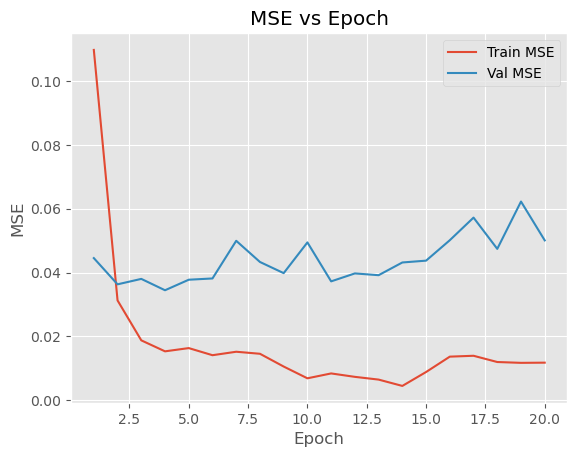

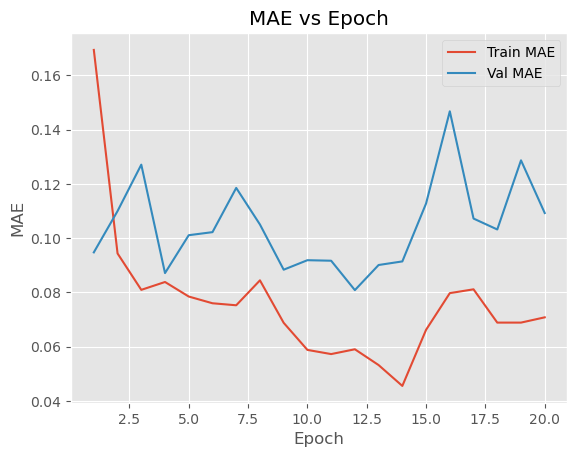

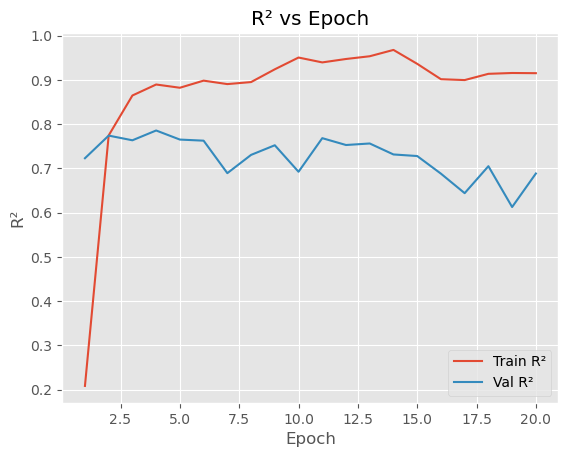

In [116]:
trainer.train(epochs=20)
trainer.plot_metrics()


In [117]:
print(f"\nFinal Train R²: {trainer.train_r2[-1]:.4f}")
print(f"Final Val R²:   {trainer.val_r2[-1]:.4f}")



Final Train R²: 0.9150
Final Val R²:   0.6884


In [118]:
# ============================
# Optuna Objective Function with Cross-Validation
# ============================
def lstm_optuna_objective_existing(trial, df, target_cols):
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 2, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    bidirectional = trial.suggest_categorical("bidirectional", [False, True])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-4])   
    batch_size = trial.suggest_categorical("batch_size", [1, 4, 8])

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_r2_scores = []

    for train_index, test_index in kf.split(df['cell_id'].unique()):
        train_cells = df['cell_id'].unique()[train_index]
        test_cells = df['cell_id'].unique()[test_index]

        train_df = df[df['cell_id'].isin(train_cells)].copy()
        test_df = df[df['cell_id'].isin(test_cells)].copy()

        trainer = BatteryTrainer(
            df=pd.concat([train_df, test_df], ignore_index=True),
            target_cols=target_cols,
            max_q=100,
            max_i=100,
            normalize=True,
            verbose=False,
            batch_size=batch_size  # 🔧 new param
        )

        trainer.model = nn.LSTM(
            input_size=len(trainer.feature_cols),
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=True
        )

        trainer.train(epochs=10, lr=lr)  # 🔧 use tuned params
        val_r2_scores.append(trainer.val_r2[-1])

    return np.mean(val_r2_scores)


In [119]:
def run_optuna_tuning(df, target_cols, n_trials):
    sampler = optuna.samplers.TPESampler(seed=42)  # ✅ fixed seed for reproducibility
    study = optuna.create_study(direction="maximize", sampler=sampler)  # ✅ maximize R²
    study.optimize(lambda trial: lstm_optuna_objective_existing(trial, df, target_cols), n_trials=n_trials)

    print("\nBest trial:")
    trial = study.best_trial
    print(f"  R²: {trial.value:.4f}")
    print("  Params:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Optional: Plot
    plt.figure()
    optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.grid(True)
    plt.show()

    plt.figure()
    optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Hyperparameter Importances")
    plt.grid(True)
    plt.show()

    return study


[I 2025-04-10 10:39:44,308] A new study created in memory with name: no-name-82d51825-3fcd-43b5-8eac-15de39a35bf1


Epoch 1: Train MSE=0.1216, Val MSE=0.0103
Epoch 2: Train MSE=0.0315, Val MSE=0.0467
Epoch 3: Train MSE=0.0110, Val MSE=0.0228
Epoch 4: Train MSE=0.0046, Val MSE=0.0187
Epoch 5: Train MSE=0.0132, Val MSE=0.0205
Epoch 6: Train MSE=0.0046, Val MSE=0.0132
Epoch 7: Train MSE=0.0051, Val MSE=0.0131
Epoch 8: Train MSE=0.0036, Val MSE=0.0119
Epoch 9: Train MSE=0.0037, Val MSE=0.0053
Epoch 10: Train MSE=0.0030, Val MSE=0.0172
Epoch 1: Train MSE=0.1290, Val MSE=0.0100
Epoch 2: Train MSE=0.0160, Val MSE=0.0134
Epoch 3: Train MSE=0.0079, Val MSE=0.0218
Epoch 4: Train MSE=0.0062, Val MSE=0.0075
Epoch 5: Train MSE=0.0165, Val MSE=0.0198
Epoch 6: Train MSE=0.0028, Val MSE=0.0055
Epoch 7: Train MSE=0.0053, Val MSE=0.0057
Epoch 8: Train MSE=0.0029, Val MSE=0.0030
Epoch 9: Train MSE=0.0050, Val MSE=0.0075
Epoch 10: Train MSE=0.0090, Val MSE=0.0063
Epoch 1: Train MSE=0.0779, Val MSE=0.0069
Epoch 2: Train MSE=0.0191, Val MSE=0.0076
Epoch 3: Train MSE=0.0073, Val MSE=0.0096
Epoch 4: Train MSE=0.0049, Val M

[I 2025-04-10 10:41:07,308] Trial 0 finished with value: 0.7388016780217489 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.07800932022121826, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 0 with value: 0.7388016780217489.


Epoch 10: Train MSE=0.0046, Val MSE=0.0081
Epoch 1: Train MSE=0.0907, Val MSE=0.0103
Epoch 2: Train MSE=0.0224, Val MSE=0.0038
Epoch 3: Train MSE=0.0167, Val MSE=0.0029
Epoch 4: Train MSE=0.0076, Val MSE=0.0029
Epoch 5: Train MSE=0.0084, Val MSE=0.0045
Epoch 6: Train MSE=0.0061, Val MSE=0.0033
Epoch 7: Train MSE=0.0062, Val MSE=0.0033
Epoch 8: Train MSE=0.0048, Val MSE=0.0034
Epoch 9: Train MSE=0.0013, Val MSE=0.0043
Epoch 10: Train MSE=0.0021, Val MSE=0.0026
Epoch 1: Train MSE=0.0944, Val MSE=0.0218
Epoch 2: Train MSE=0.0275, Val MSE=0.0173
Epoch 3: Train MSE=0.0071, Val MSE=0.0163
Epoch 4: Train MSE=0.0147, Val MSE=0.0187
Epoch 5: Train MSE=0.0048, Val MSE=0.0123
Epoch 6: Train MSE=0.0043, Val MSE=0.0241
Epoch 7: Train MSE=0.0039, Val MSE=0.0130
Epoch 8: Train MSE=0.0015, Val MSE=0.0118
Epoch 9: Train MSE=0.0025, Val MSE=0.0120
Epoch 10: Train MSE=0.0007, Val MSE=0.0127
Epoch 1: Train MSE=0.1082, Val MSE=0.0244
Epoch 2: Train MSE=0.0131, Val MSE=0.0138
Epoch 3: Train MSE=0.0181, Val 

[I 2025-04-10 10:42:22,326] Trial 1 finished with value: 0.7257946928342184 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.15212112147976886, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 0 with value: 0.7388016780217489.


Epoch 10: Train MSE=0.0022, Val MSE=0.0097
Epoch 1: Train MSE=0.1624, Val MSE=0.0095
Epoch 2: Train MSE=0.0398, Val MSE=0.0041
Epoch 3: Train MSE=0.0176, Val MSE=0.0066
Epoch 4: Train MSE=0.0088, Val MSE=0.0111
Epoch 5: Train MSE=0.0078, Val MSE=0.0078
Epoch 6: Train MSE=0.0080, Val MSE=0.0091
Epoch 7: Train MSE=0.0089, Val MSE=0.0083
Epoch 8: Train MSE=0.0045, Val MSE=0.0044
Epoch 9: Train MSE=0.0031, Val MSE=0.0047
Epoch 10: Train MSE=0.0050, Val MSE=0.0058
Epoch 1: Train MSE=0.0741, Val MSE=0.0082
Epoch 2: Train MSE=0.0269, Val MSE=0.0058
Epoch 3: Train MSE=0.0076, Val MSE=0.0057
Epoch 4: Train MSE=0.0077, Val MSE=0.0019
Epoch 5: Train MSE=0.0067, Val MSE=0.0013
Epoch 6: Train MSE=0.0051, Val MSE=0.0035
Epoch 7: Train MSE=0.0054, Val MSE=0.0046
Epoch 8: Train MSE=0.0045, Val MSE=0.0066
Epoch 9: Train MSE=0.0063, Val MSE=0.0043
Epoch 10: Train MSE=0.0066, Val MSE=0.0039
Epoch 1: Train MSE=0.1025, Val MSE=0.0179
Epoch 2: Train MSE=0.0173, Val MSE=0.0227
Epoch 3: Train MSE=0.0083, Val 

[I 2025-04-10 10:43:37,698] Trial 2 finished with value: 0.9050314426422119 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.29620728443102123, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0040, Val MSE=0.0036
Epoch 1: Train MSE=0.0840, Val MSE=0.0278
Epoch 2: Train MSE=0.0242, Val MSE=0.0180
Epoch 3: Train MSE=0.0192, Val MSE=0.0182
Epoch 4: Train MSE=0.0167, Val MSE=0.0188
Epoch 5: Train MSE=0.0118, Val MSE=0.0229
Epoch 6: Train MSE=0.0144, Val MSE=0.0161
Epoch 7: Train MSE=0.0092, Val MSE=0.0160
Epoch 8: Train MSE=0.0117, Val MSE=0.0258
Epoch 9: Train MSE=0.0107, Val MSE=0.0323
Epoch 10: Train MSE=0.0120, Val MSE=0.0407
Epoch 1: Train MSE=0.1103, Val MSE=0.0380
Epoch 2: Train MSE=0.0334, Val MSE=0.0367
Epoch 3: Train MSE=0.0185, Val MSE=0.0244
Epoch 4: Train MSE=0.0232, Val MSE=0.0245
Epoch 5: Train MSE=0.0219, Val MSE=0.0256
Epoch 6: Train MSE=0.0196, Val MSE=0.0383
Epoch 7: Train MSE=0.0154, Val MSE=0.0398
Epoch 8: Train MSE=0.0139, Val MSE=0.0446
Epoch 9: Train MSE=0.0145, Val MSE=0.0223
Epoch 10: Train MSE=0.0152, Val MSE=0.0417
Epoch 1: Train MSE=0.1199, Val MSE=0.0747
Epoch 2: Train MSE=0.0412, Val MSE=0.0504
Epoch 3: Train MSE=0.0243, Val 

[I 2025-04-10 10:45:14,643] Trial 3 finished with value: 0.6557498971621195 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.06101911742238941, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0141, Val MSE=0.0535
Epoch 1: Train MSE=0.1088, Val MSE=0.0373
Epoch 2: Train MSE=0.0239, Val MSE=0.0130
Epoch 3: Train MSE=0.0120, Val MSE=0.0063
Epoch 4: Train MSE=0.0128, Val MSE=0.0046
Epoch 5: Train MSE=0.0044, Val MSE=0.0030
Epoch 6: Train MSE=0.0053, Val MSE=0.0028
Epoch 7: Train MSE=0.0030, Val MSE=0.0020
Epoch 8: Train MSE=0.0027, Val MSE=0.0031
Epoch 9: Train MSE=0.0020, Val MSE=0.0028
Epoch 10: Train MSE=0.0023, Val MSE=0.0052
Epoch 1: Train MSE=0.0765, Val MSE=0.0095
Epoch 2: Train MSE=0.0123, Val MSE=0.0072
Epoch 3: Train MSE=0.0078, Val MSE=0.0075
Epoch 4: Train MSE=0.0058, Val MSE=0.0031
Epoch 5: Train MSE=0.0070, Val MSE=0.0048
Epoch 6: Train MSE=0.0046, Val MSE=0.0060
Epoch 7: Train MSE=0.0058, Val MSE=0.0046
Epoch 8: Train MSE=0.0024, Val MSE=0.0046
Epoch 9: Train MSE=0.0055, Val MSE=0.0117
Epoch 10: Train MSE=0.0112, Val MSE=0.0094
Epoch 1: Train MSE=0.0723, Val MSE=0.0056
Epoch 2: Train MSE=0.0241, Val MSE=0.0048
Epoch 3: Train MSE=0.0127, Val 

[I 2025-04-10 10:46:26,456] Trial 4 finished with value: 0.8357821106910706 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.46974947078209456, 'bidirectional': False, 'lr': 0.001, 'batch_size': 8}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0049, Val MSE=0.0023
Epoch 1: Train MSE=0.1372, Val MSE=0.0275
Epoch 2: Train MSE=0.0245, Val MSE=0.0148
Epoch 3: Train MSE=0.0188, Val MSE=0.0121
Epoch 4: Train MSE=0.0165, Val MSE=0.0105
Epoch 5: Train MSE=0.0150, Val MSE=0.0107
Epoch 6: Train MSE=0.0138, Val MSE=0.0138
Epoch 7: Train MSE=0.0125, Val MSE=0.0135
Epoch 8: Train MSE=0.0118, Val MSE=0.0385
Epoch 9: Train MSE=0.0173, Val MSE=0.0193
Epoch 10: Train MSE=0.0123, Val MSE=0.0081
Epoch 1: Train MSE=0.1405, Val MSE=0.0531
Epoch 2: Train MSE=0.0382, Val MSE=0.0293
Epoch 3: Train MSE=0.0161, Val MSE=0.0276
Epoch 4: Train MSE=0.0134, Val MSE=0.0297
Epoch 5: Train MSE=0.0148, Val MSE=0.0413
Epoch 6: Train MSE=0.0122, Val MSE=0.0242
Epoch 7: Train MSE=0.0102, Val MSE=0.0248
Epoch 8: Train MSE=0.0090, Val MSE=0.0363
Epoch 9: Train MSE=0.0119, Val MSE=0.0453
Epoch 10: Train MSE=0.0149, Val MSE=0.0305
Epoch 1: Train MSE=0.1338, Val MSE=0.0468
Epoch 2: Train MSE=0.0309, Val MSE=0.0321
Epoch 3: Train MSE=0.0246, Val 

[I 2025-04-10 10:48:12,914] Trial 5 finished with value: 0.8074608643849691 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.14046725484369038, 'bidirectional': False, 'lr': 0.001, 'batch_size': 1}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0128, Val MSE=0.0350
Epoch 1: Train MSE=0.0897, Val MSE=0.0302
Epoch 2: Train MSE=0.0099, Val MSE=0.0205
Epoch 3: Train MSE=0.0054, Val MSE=0.0237
Epoch 4: Train MSE=0.0039, Val MSE=0.0319
Epoch 5: Train MSE=0.0042, Val MSE=0.0227
Epoch 6: Train MSE=0.0027, Val MSE=0.0232
Epoch 7: Train MSE=0.0024, Val MSE=0.0157
Epoch 8: Train MSE=0.0039, Val MSE=0.0285
Epoch 9: Train MSE=0.0040, Val MSE=0.0186
Epoch 10: Train MSE=0.0032, Val MSE=0.0187
Epoch 1: Train MSE=0.1271, Val MSE=0.0876
Epoch 2: Train MSE=0.0122, Val MSE=0.0702
Epoch 3: Train MSE=0.0042, Val MSE=0.0692
Epoch 4: Train MSE=0.0030, Val MSE=0.0648
Epoch 5: Train MSE=0.0045, Val MSE=0.0666
Epoch 6: Train MSE=0.0033, Val MSE=0.0620
Epoch 7: Train MSE=0.0033, Val MSE=0.0651
Epoch 8: Train MSE=0.0028, Val MSE=0.0590
Epoch 9: Train MSE=0.0026, Val MSE=0.0574
Epoch 10: Train MSE=0.0030, Val MSE=0.0654
Epoch 1: Train MSE=0.0829, Val MSE=0.0767
Epoch 2: Train MSE=0.0117, Val MSE=0.0591
Epoch 3: Train MSE=0.0064, Val 

[I 2025-04-10 10:49:51,649] Trial 6 finished with value: 0.6356895565986633 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.38563517334297287, 'bidirectional': True, 'lr': 0.0001, 'batch_size': 1}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0051, Val MSE=0.0526
Epoch 1: Train MSE=0.1105, Val MSE=0.0054
Epoch 2: Train MSE=0.0307, Val MSE=0.0057
Epoch 3: Train MSE=0.0048, Val MSE=0.0030
Epoch 4: Train MSE=0.0164, Val MSE=0.0042
Epoch 5: Train MSE=0.0076, Val MSE=0.0030
Epoch 6: Train MSE=0.0022, Val MSE=0.0024
Epoch 7: Train MSE=0.0015, Val MSE=0.0037
Epoch 8: Train MSE=0.0007, Val MSE=0.0026
Epoch 9: Train MSE=0.0019, Val MSE=0.0036
Epoch 10: Train MSE=0.0008, Val MSE=0.0024
Epoch 1: Train MSE=0.1420, Val MSE=0.0298
Epoch 2: Train MSE=0.0175, Val MSE=0.0136
Epoch 3: Train MSE=0.0091, Val MSE=0.0135
Epoch 4: Train MSE=0.0040, Val MSE=0.0116
Epoch 5: Train MSE=0.0038, Val MSE=0.0096
Epoch 6: Train MSE=0.0018, Val MSE=0.0076
Epoch 7: Train MSE=0.0022, Val MSE=0.0079
Epoch 8: Train MSE=0.0009, Val MSE=0.0083
Epoch 9: Train MSE=0.0009, Val MSE=0.0102
Epoch 10: Train MSE=0.0025, Val MSE=0.0099
Epoch 1: Train MSE=0.0687, Val MSE=0.0103
Epoch 2: Train MSE=0.0219, Val MSE=0.0088
Epoch 3: Train MSE=0.0073, Val 

[I 2025-04-10 10:51:09,426] Trial 7 finished with value: 0.8588176369667053 and parameters: {'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.44360637128816327, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 4}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0005, Val MSE=0.0046
Epoch 1: Train MSE=0.0768, Val MSE=0.0115
Epoch 2: Train MSE=0.0201, Val MSE=0.0031
Epoch 3: Train MSE=0.0091, Val MSE=0.0050
Epoch 4: Train MSE=0.0070, Val MSE=0.0026
Epoch 5: Train MSE=0.0113, Val MSE=0.0037
Epoch 6: Train MSE=0.0016, Val MSE=0.0024
Epoch 7: Train MSE=0.0031, Val MSE=0.0019
Epoch 8: Train MSE=0.0053, Val MSE=0.0021
Epoch 9: Train MSE=0.0030, Val MSE=0.0021
Epoch 10: Train MSE=0.0018, Val MSE=0.0017
Epoch 1: Train MSE=0.0890, Val MSE=0.0254
Epoch 2: Train MSE=0.0123, Val MSE=0.0168
Epoch 3: Train MSE=0.0067, Val MSE=0.0113
Epoch 4: Train MSE=0.0171, Val MSE=0.0122
Epoch 5: Train MSE=0.0091, Val MSE=0.0075
Epoch 6: Train MSE=0.0020, Val MSE=0.0094
Epoch 7: Train MSE=0.0008, Val MSE=0.0077
Epoch 8: Train MSE=0.0102, Val MSE=0.0081
Epoch 9: Train MSE=0.0019, Val MSE=0.0098
Epoch 10: Train MSE=0.0027, Val MSE=0.0098
Epoch 1: Train MSE=0.1060, Val MSE=0.0129
Epoch 2: Train MSE=0.0334, Val MSE=0.0098
Epoch 3: Train MSE=0.0071, Val 

[I 2025-04-10 10:52:23,976] Trial 8 finished with value: 0.815131147702535 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.015714592843367126, 'bidirectional': False, 'lr': 0.0001, 'batch_size': 8}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0014, Val MSE=0.0054
Epoch 1: Train MSE=0.0903, Val MSE=0.0218
Epoch 2: Train MSE=0.0158, Val MSE=0.0111
Epoch 3: Train MSE=0.0140, Val MSE=0.0108
Epoch 4: Train MSE=0.0108, Val MSE=0.0094
Epoch 5: Train MSE=0.0062, Val MSE=0.0096
Epoch 6: Train MSE=0.0042, Val MSE=0.0089
Epoch 7: Train MSE=0.0058, Val MSE=0.0036
Epoch 8: Train MSE=0.0040, Val MSE=0.0087
Epoch 9: Train MSE=0.0031, Val MSE=0.0067
Epoch 10: Train MSE=0.0058, Val MSE=0.0071
Epoch 1: Train MSE=0.0851, Val MSE=0.0300
Epoch 2: Train MSE=0.0241, Val MSE=0.0071
Epoch 3: Train MSE=0.0073, Val MSE=0.0040
Epoch 4: Train MSE=0.0067, Val MSE=0.0121
Epoch 5: Train MSE=0.0046, Val MSE=0.0067
Epoch 6: Train MSE=0.0088, Val MSE=0.0100
Epoch 7: Train MSE=0.0064, Val MSE=0.0064
Epoch 8: Train MSE=0.0067, Val MSE=0.0057
Epoch 9: Train MSE=0.0091, Val MSE=0.0103
Epoch 10: Train MSE=0.0074, Val MSE=0.0080
Epoch 1: Train MSE=0.1012, Val MSE=0.0100
Epoch 2: Train MSE=0.0281, Val MSE=0.0187
Epoch 3: Train MSE=0.0144, Val 

[I 2025-04-10 10:53:41,420] Trial 9 finished with value: 0.8093451857566833 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.46484882617128653, 'bidirectional': False, 'lr': 0.001, 'batch_size': 4}. Best is trial 2 with value: 0.9050314426422119.


Epoch 10: Train MSE=0.0046, Val MSE=0.0110
Epoch 1: Train MSE=0.0623, Val MSE=0.0189
Epoch 2: Train MSE=0.0127, Val MSE=0.0097
Epoch 3: Train MSE=0.0198, Val MSE=0.0054
Epoch 4: Train MSE=0.0087, Val MSE=0.0029
Epoch 5: Train MSE=0.0038, Val MSE=0.0051
Epoch 6: Train MSE=0.0089, Val MSE=0.0133
Epoch 7: Train MSE=0.0086, Val MSE=0.0040
Epoch 8: Train MSE=0.0043, Val MSE=0.0035
Epoch 9: Train MSE=0.0043, Val MSE=0.0031
Epoch 10: Train MSE=0.0023, Val MSE=0.0046
Epoch 1: Train MSE=0.1490, Val MSE=0.0082
Epoch 2: Train MSE=0.0193, Val MSE=0.0069
Epoch 3: Train MSE=0.0142, Val MSE=0.0038
Epoch 4: Train MSE=0.0059, Val MSE=0.0053
Epoch 5: Train MSE=0.0064, Val MSE=0.0042
Epoch 6: Train MSE=0.0051, Val MSE=0.0036
Epoch 7: Train MSE=0.0062, Val MSE=0.0035
Epoch 8: Train MSE=0.0056, Val MSE=0.0055
Epoch 9: Train MSE=0.0059, Val MSE=0.0029
Epoch 10: Train MSE=0.0054, Val MSE=0.0031
Epoch 1: Train MSE=0.0877, Val MSE=0.0356
Epoch 2: Train MSE=0.0448, Val MSE=0.0116
Epoch 3: Train MSE=0.0118, Val 

[I 2025-04-10 10:54:57,559] Trial 10 finished with value: 0.9175044099489847 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.28478407918358883, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 10 with value: 0.9175044099489847.


Epoch 10: Train MSE=0.0030, Val MSE=0.0041
Epoch 1: Train MSE=0.1852, Val MSE=0.0073
Epoch 2: Train MSE=0.0293, Val MSE=0.0060
Epoch 3: Train MSE=0.0158, Val MSE=0.0091
Epoch 4: Train MSE=0.0087, Val MSE=0.0038
Epoch 5: Train MSE=0.0074, Val MSE=0.0025
Epoch 6: Train MSE=0.0062, Val MSE=0.0049
Epoch 7: Train MSE=0.0054, Val MSE=0.0031
Epoch 8: Train MSE=0.0045, Val MSE=0.0019
Epoch 9: Train MSE=0.0048, Val MSE=0.0030
Epoch 10: Train MSE=0.0046, Val MSE=0.0040
Epoch 1: Train MSE=0.1065, Val MSE=0.0047
Epoch 2: Train MSE=0.0117, Val MSE=0.0062
Epoch 3: Train MSE=0.0069, Val MSE=0.0109
Epoch 4: Train MSE=0.0069, Val MSE=0.0071
Epoch 5: Train MSE=0.0070, Val MSE=0.0100
Epoch 6: Train MSE=0.0073, Val MSE=0.0041
Epoch 7: Train MSE=0.0045, Val MSE=0.0042
Epoch 8: Train MSE=0.0058, Val MSE=0.0041
Epoch 9: Train MSE=0.0046, Val MSE=0.0016
Epoch 10: Train MSE=0.0022, Val MSE=0.0043
Epoch 1: Train MSE=0.1155, Val MSE=0.0096
Epoch 2: Train MSE=0.0164, Val MSE=0.0083
Epoch 3: Train MSE=0.0130, Val 

[I 2025-04-10 10:56:10,731] Trial 11 finished with value: 0.9123848676681519 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.2852739324408416, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 10 with value: 0.9175044099489847.


Epoch 10: Train MSE=0.0026, Val MSE=0.0036
Epoch 1: Train MSE=0.0978, Val MSE=0.0190
Epoch 2: Train MSE=0.0224, Val MSE=0.0098
Epoch 3: Train MSE=0.0166, Val MSE=0.0030
Epoch 4: Train MSE=0.0053, Val MSE=0.0035
Epoch 5: Train MSE=0.0071, Val MSE=0.0041
Epoch 6: Train MSE=0.0056, Val MSE=0.0045
Epoch 7: Train MSE=0.0080, Val MSE=0.0084
Epoch 8: Train MSE=0.0066, Val MSE=0.0047
Epoch 9: Train MSE=0.0070, Val MSE=0.0040
Epoch 10: Train MSE=0.0055, Val MSE=0.0049
Epoch 1: Train MSE=0.1079, Val MSE=0.0208
Epoch 2: Train MSE=0.0128, Val MSE=0.0084
Epoch 3: Train MSE=0.0112, Val MSE=0.0088
Epoch 4: Train MSE=0.0101, Val MSE=0.0218
Epoch 5: Train MSE=0.0147, Val MSE=0.0151
Epoch 6: Train MSE=0.0076, Val MSE=0.0066
Epoch 7: Train MSE=0.0052, Val MSE=0.0064
Epoch 8: Train MSE=0.0052, Val MSE=0.0039
Epoch 9: Train MSE=0.0070, Val MSE=0.0040
Epoch 10: Train MSE=0.0048, Val MSE=0.0044
Epoch 1: Train MSE=0.1110, Val MSE=0.0214
Epoch 2: Train MSE=0.0309, Val MSE=0.0207
Epoch 3: Train MSE=0.0076, Val 

[I 2025-04-10 10:57:24,539] Trial 12 finished with value: 0.8789941867192587 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.289557307983231, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 10 with value: 0.9175044099489847.


Epoch 10: Train MSE=0.0068, Val MSE=0.0076
Epoch 1: Train MSE=0.0945, Val MSE=0.0122
Epoch 2: Train MSE=0.0209, Val MSE=0.0096
Epoch 3: Train MSE=0.0142, Val MSE=0.0041
Epoch 4: Train MSE=0.0060, Val MSE=0.0023
Epoch 5: Train MSE=0.0065, Val MSE=0.0029
Epoch 6: Train MSE=0.0042, Val MSE=0.0020
Epoch 7: Train MSE=0.0040, Val MSE=0.0009
Epoch 8: Train MSE=0.0056, Val MSE=0.0006
Epoch 9: Train MSE=0.0028, Val MSE=0.0014
Epoch 10: Train MSE=0.0051, Val MSE=0.0063
Epoch 1: Train MSE=0.1661, Val MSE=0.0067
Epoch 2: Train MSE=0.0323, Val MSE=0.0067
Epoch 3: Train MSE=0.0135, Val MSE=0.0087
Epoch 4: Train MSE=0.0164, Val MSE=0.0042
Epoch 5: Train MSE=0.0051, Val MSE=0.0032
Epoch 6: Train MSE=0.0067, Val MSE=0.0033
Epoch 7: Train MSE=0.0046, Val MSE=0.0029
Epoch 8: Train MSE=0.0054, Val MSE=0.0048
Epoch 9: Train MSE=0.0036, Val MSE=0.0015
Epoch 10: Train MSE=0.0022, Val MSE=0.0023
Epoch 1: Train MSE=0.0973, Val MSE=0.0205
Epoch 2: Train MSE=0.0141, Val MSE=0.0147
Epoch 3: Train MSE=0.0236, Val 

[I 2025-04-10 10:58:36,406] Trial 13 finished with value: 0.867662787437439 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.2081598596990184, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 10 with value: 0.9175044099489847.


Epoch 10: Train MSE=0.0042, Val MSE=0.0111
Epoch 1: Train MSE=0.1314, Val MSE=0.0096
Epoch 2: Train MSE=0.0265, Val MSE=0.0041
Epoch 3: Train MSE=0.0098, Val MSE=0.0038
Epoch 4: Train MSE=0.0145, Val MSE=0.0133
Epoch 5: Train MSE=0.0091, Val MSE=0.0048
Epoch 6: Train MSE=0.0080, Val MSE=0.0057
Epoch 7: Train MSE=0.0042, Val MSE=0.0071
Epoch 8: Train MSE=0.0052, Val MSE=0.0070
Epoch 9: Train MSE=0.0056, Val MSE=0.0047
Epoch 10: Train MSE=0.0041, Val MSE=0.0035
Epoch 1: Train MSE=0.1415, Val MSE=0.0066
Epoch 2: Train MSE=0.0114, Val MSE=0.0047
Epoch 3: Train MSE=0.0164, Val MSE=0.0049
Epoch 4: Train MSE=0.0084, Val MSE=0.0038
Epoch 5: Train MSE=0.0075, Val MSE=0.0056
Epoch 6: Train MSE=0.0080, Val MSE=0.0043
Epoch 7: Train MSE=0.0098, Val MSE=0.0054
Epoch 8: Train MSE=0.0053, Val MSE=0.0063
Epoch 9: Train MSE=0.0077, Val MSE=0.0073
Epoch 10: Train MSE=0.0063, Val MSE=0.0032
Epoch 1: Train MSE=0.1640, Val MSE=0.0147
Epoch 2: Train MSE=0.0343, Val MSE=0.0192
Epoch 3: Train MSE=0.0126, Val 

[I 2025-04-10 10:59:51,925] Trial 14 finished with value: 0.8561096986134847 and parameters: {'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.3422242688736209, 'bidirectional': True, 'lr': 0.001, 'batch_size': 4}. Best is trial 10 with value: 0.9175044099489847.


Epoch 10: Train MSE=0.0062, Val MSE=0.0138

Best trial:
  R²: 0.9175
  Params:
    hidden_dim: 128
    num_layers: 3
    dropout: 0.28478407918358883
    bidirectional: True
    lr: 0.001
    batch_size: 4


/var/folders/tk/zrl6dpm93_z3b4xw74jhlbjm0000gn/T/ipykernel_29958/169117308.py:15: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Figure size 640x480 with 0 Axes>

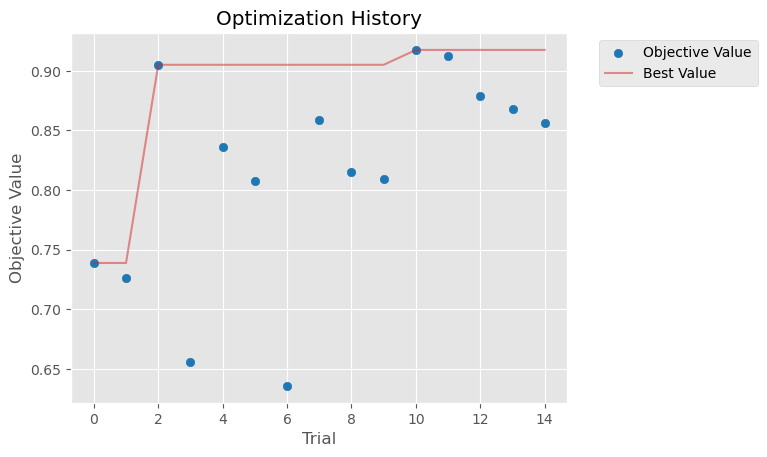

/var/folders/tk/zrl6dpm93_z3b4xw74jhlbjm0000gn/T/ipykernel_29958/169117308.py:21: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Figure size 640x480 with 0 Axes>

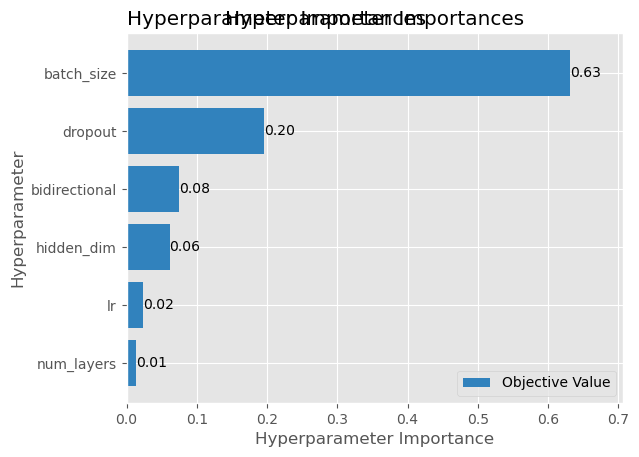

In [120]:
study_lstm = run_optuna_tuning(df_merged, target_cols=["capacity"], n_trials=15)


/var/folders/tk/zrl6dpm93_z3b4xw74jhlbjm0000gn/T/ipykernel_29958/3055246662.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study_lstm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

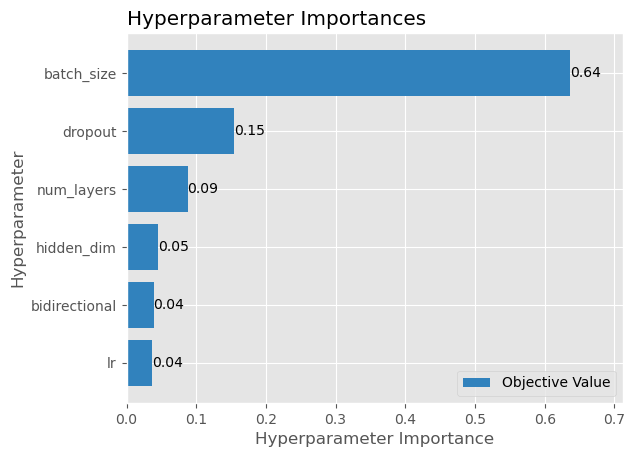

In [121]:
optuna.visualization.matplotlib.plot_param_importances(study_lstm)

/var/folders/tk/zrl6dpm93_z3b4xw74jhlbjm0000gn/T/ipykernel_29958/3184292093.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_lstm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

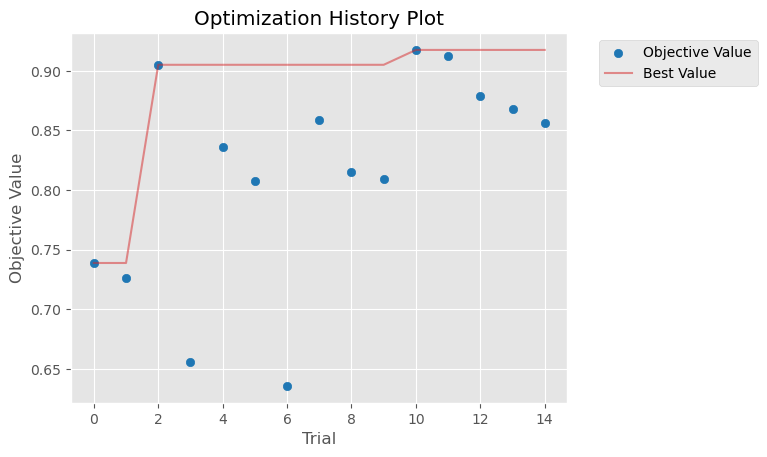

In [122]:
optuna.visualization.matplotlib.plot_optimization_history(study_lstm)


[nasa] Normalizing 3002 features
[oxford] Normalizing 3001 features
[isu] Normalizing 3001 features
Epoch 1: Train MSE=0.1074, Val MSE=0.0048
Epoch 2: Train MSE=0.0231, Val MSE=0.0061
Epoch 3: Train MSE=0.0093, Val MSE=0.0035
Epoch 4: Train MSE=0.0065, Val MSE=0.0029
Epoch 5: Train MSE=0.0047, Val MSE=0.0052
Epoch 6: Train MSE=0.0031, Val MSE=0.0012
Epoch 7: Train MSE=0.0025, Val MSE=0.0061
Epoch 8: Train MSE=0.0021, Val MSE=0.0015
Epoch 9: Train MSE=0.0018, Val MSE=0.0030
Epoch 10: Train MSE=0.0017, Val MSE=0.0010
Epoch 11: Train MSE=0.0042, Val MSE=0.0023
Epoch 12: Train MSE=0.0030, Val MSE=0.0042
Epoch 13: Train MSE=0.0031, Val MSE=0.0027
Epoch 14: Train MSE=0.0028, Val MSE=0.0041
Epoch 15: Train MSE=0.0043, Val MSE=0.0046
Epoch 16: Train MSE=0.0030, Val MSE=0.0066
Epoch 17: Train MSE=0.0046, Val MSE=0.0033
Epoch 18: Train MSE=0.0045, Val MSE=0.0053
Epoch 19: Train MSE=0.0073, Val MSE=0.0038
Epoch 20: Train MSE=0.0034, Val MSE=0.0035


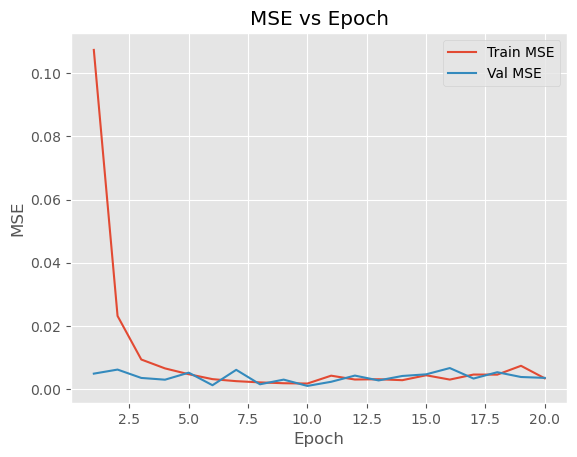

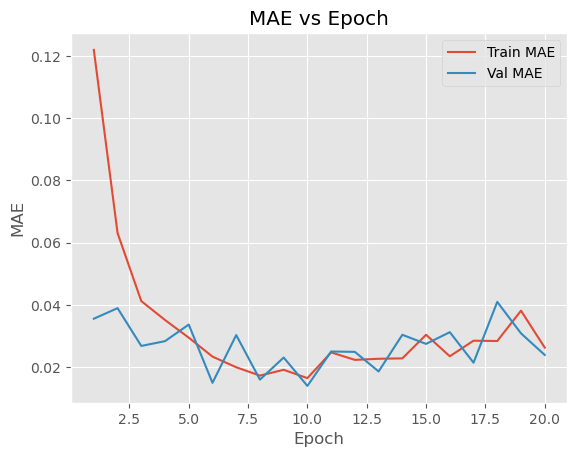

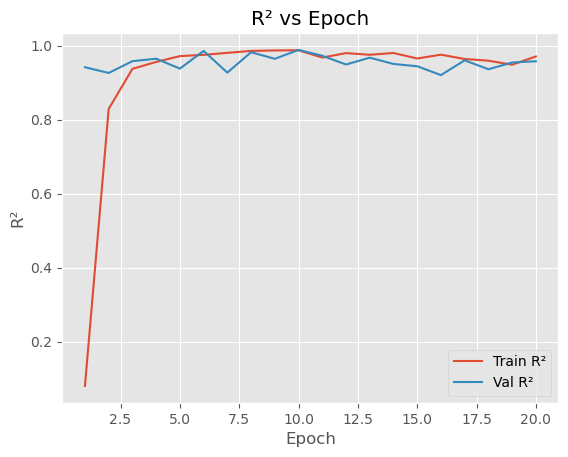

In [123]:
trainer_best = BatteryTrainer(
    df=df_merged,
    target_cols=["capacity"],
    batch_size=4,        # ✅ from Optuna
    verbose=True
)

# Override the model with the best LSTM configuration from Optuna
trainer_best.model = nn.LSTM(
    input_size=len(trainer_best.feature_cols),
    hidden_size=128,              # ✅ from Optuna
    num_layers=3,                 # ✅ from Optuna
    dropout=0.28478407918358883,  # ✅ from Optuna
    bidirectional=True,           # ✅ from Optuna
    batch_first=True
)

# Train using the best learning rate from Optuna
trainer_best.train(epochs=20, lr=0.001)

# Plot the metrics
trainer_best.plot_metrics()

In [124]:
print(f"\nFinal Train R²: {trainer_best.train_r2[-1]:.4f}")
print(f"Final Val R²:   {trainer_best.val_r2[-1]:.4f}")



Final Train R²: 0.9708
Final Val R²:   0.9579
